Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from load_and_generate import *

In [2]:
pickle_file = 'exploration.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 32, 32) (8432,)
Validation set (2811, 32, 32) (2811,)
Test set (2811, 32, 32) (2811,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_width = 32
image_height = 32

num_labels = 2
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_width, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 32, 32, 1) (8432, 2)
Validation set (2811, 32, 32, 1) (2811, 2)
Test set (2811, 32, 32, 1) (2811, 2)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Lenet-5

In [15]:
#Lenet 5 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/


batch_size_array = [5, 10, 15]
lr = [1e-5, 1e-5, 1e-5] #alpha
#beta = [2e-3, 5e-3, 1e-3]
beta = [0, 0, 0]
valid_accuracy_array = []
valid_auc_array = []
test_accuracy_array = []
test_auc_array = []
pred_step_array = []
from sklearn.metrics import roc_auc_score

for i, batch_size in enumerate(batch_size_array):
        
    print ("batch size:%d \n"%batch_size)
    num_steps = train_dataset.shape[0] // batch_size
    print ("num_steps:%d" %num_steps)
    #batch_size = 10
    num_channels = 1
    stride = 2 #1 very common


    depth_1 = 6
    depth_2 = 6
    depth_3 = 16
    depth_4 = 16
    depth_5 = 120

    patch_size_1 = 5
    patch_size_2 = 2
    patch_size_3 = 6
    patch_size_4 = 2
    patch_size_5 = 6
    
    valid_accuracy = []
    valid_auc = []
    test_accuracy = []
    test_auc = []
    pred_step = []


    graph = tf.Graph()

    with graph.as_default():

      # Input data.
      tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_height, image_width, num_channels))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size_1, patch_size_1, num_channels, 6], stddev=0.1))
      layer1_biases = tf.Variable(tf.zeros([6]))
      layer3_weights = tf.Variable(tf.truncated_normal(
          [patch_size_3, patch_size_3, depth_2, depth_3], stddev=0.1))
      layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))


      layer5_weights = tf.Variable(tf.truncated_normal(
          [(image_height // ( patch_size_2*patch_size_4*stride*stride)) * (image_width // (patch_size_2*patch_size_4*stride*stride)) * depth_3, depth_5], stddev=0.1)) #modified for variable height and width  
      #print (layer3_weights.get_shape().as_list())
      layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth_5]))
      layer6_weights = tf.Variable(tf.truncated_normal(
          [depth_5, num_labels], stddev=0.1))
      layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


      # Model.
      def model(data):
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride, stride, 1], padding='SAME')
        print (conv1.get_shape().as_list())
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        pool2 = tf.nn.max_pool(hidden1, ksize=[1, patch_size_2, patch_size_2, 1], strides=[1, patch_size_2, patch_size_2, 1], 
                               padding='VALID')
        print (pool2.get_shape().as_list())

        conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, stride, stride, 1], padding='SAME')
        print (conv3.get_shape().as_list())
        hidden3 = tf.nn.relu(conv3 + layer3_biases)
        pool4 = tf.nn.max_pool(hidden3, ksize=[1,  patch_size_4, patch_size_4 , 1], strides=[1, patch_size_4, patch_size_4, 1], 
                               padding='SAME')    

        print (pool4.get_shape().as_list())

        shape = pool4.get_shape().as_list()

        reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])    

        hidden5 = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
        #print (hidden5.get_shape().as_list())  

        return (tf.matmul(hidden5, layer6_weights) + layer6_biases)


      # Training computation.
      logits = model(tf_train_dataset)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))


      #Regularization: 

      regularization_beta = beta[i] 
      regularizers = (tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + 
                       tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))

      loss = loss + regularization_beta * regularizers
      # Optimizer.
      # Optimizer.
      # We are going to find the minimum of this loss using gradient descent.
      #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
      #decaying learning rate:
      starting_learning_rate = lr[i]
      learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 0.85*num_steps, 0.96, 
                                                 staircase=True)
      optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
      test_prediction = tf.nn.softmax(model(tf_test_dataset))
        
        
        
        
    from sklearn.metrics import roc_auc_score

    with tf.device('/gpu:0'):
        with tf.Session(graph=graph) as session:
          tf.initialize_all_variables().run()
          print('Initialized')
          for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 250 == 0):
              print('Minibatch loss at step %d: %f' % (step, l))
              print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
              print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
              print('AUC: %.3f' %  roc_auc_score(valid_labels, valid_prediction.eval()))
              print (".................")

            if (step % 5 == 0):
              valid_accuracy.append(accuracy(
                    valid_prediction.eval(), valid_labels))
              valid_auc.append(roc_auc_score(valid_labels, valid_prediction.eval()))
              test_accuracy.append(accuracy(
                    test_prediction.eval(), test_labels))
              test_auc.append(roc_auc_score(test_labels, test_prediction.eval()))
              pred_step.append(step)
          print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
          valid_accuracy_array.append(valid_accuracy)
          valid_auc_array.append(valid_auc)
          test_accuracy_array.append(test_accuracy)
          test_auc_array.append(test_auc)
          pred_step_array.append(pred_step)
          print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
          print('Test AUC ROC: %.3f' %  roc_auc_score(test_labels, test_prediction.eval())) 
          print("-----------------------------------------\n")

batch size:5 

num_steps:1686
[5, 16, 16, 6]
[5, 8, 8, 6]
[5, 4, 4, 16]
[5, 2, 2, 16]
[2811, 16, 16, 6]
[2811, 8, 8, 6]
[2811, 4, 4, 16]
[2811, 2, 2, 16]
[2811, 16, 16, 6]
[2811, 8, 8, 6]
[2811, 4, 4, 16]
[2811, 2, 2, 16]
Initialized
Minibatch loss at step 0: 20.069958
Minibatch accuracy: 60.0%
Validation accuracy: 46.2%
AUC: 0.450
.................
Minibatch loss at step 250: 5.426851
Minibatch accuracy: 80.0%
Validation accuracy: 71.4%
AUC: 0.771
.................
Minibatch loss at step 500: 0.934231
Minibatch accuracy: 60.0%
Validation accuracy: 75.0%
AUC: 0.809
.................
Minibatch loss at step 750: 1.844262
Minibatch accuracy: 80.0%
Validation accuracy: 76.8%
AUC: 0.823
.................
Minibatch loss at step 1000: 0.568710
Minibatch accuracy: 80.0%
Validation accuracy: 77.5%
AUC: 0.835
.................
Minibatch loss at step 1250: 2.853081
Minibatch accuracy: 80.0%
Validation accuracy: 77.7%
AUC: 0.840
.................
Minibatch loss at step 1500: 5.233134
Minibatch acc

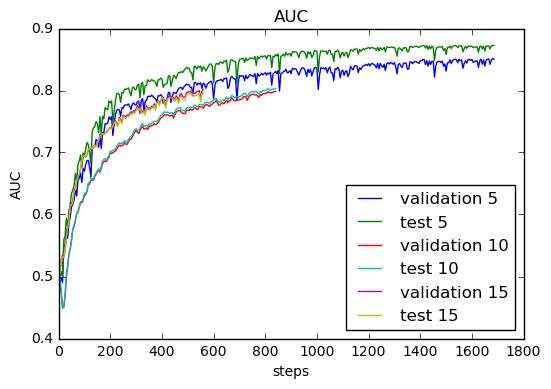

In [16]:
for i in range(len(pred_step_array)):
    plt.plot(pred_step_array[i],valid_auc_array[i], label= 'validation %d'%batch_size_array[i])
    plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %d'%batch_size_array[i])
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(loc= "best")
plt.title ("AUC")
plt.show()

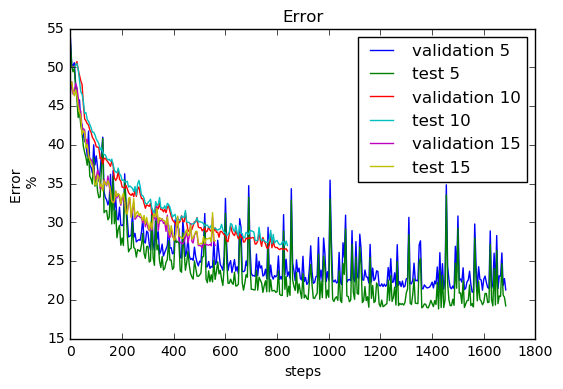

In [17]:
for i in range(len(pred_step_array)):
    plt.plot(pred_step_array[i], [100. - x for x in valid_accuracy_array[i]], label= 'validation %d'%batch_size_array[i])
    plt.plot(pred_step_array[i], [100. - x for x in test_accuracy_array[i]], label= 'test %d'%batch_size_array[i])
plt.xlabel('steps')
plt.ylabel('Error \n %')
plt.legend(loc= "best")
plt.title ("Error")
plt.show()

### Lenet-5 with Batch normalization

In [175]:
#Lenet 5 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

class lenet5_BN():

    def __init__(self, train_dataset, valid_dataset, test_dataset, train_labels,
                 valid_labels, test_labels,**kwargs):
        self.image_width = 32
        self.image_height = 32
        self.num_channels = 1
        self.recording_step = 50
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset 
        self.test_dataset = test_dataset
        
        self.train_labels = train_labels
        self.valid_labels = valid_labels 
        self.test_labels = test_labels
        
        self.valid_accuracy_array = []
        self.valid_auc_array = []
        self.test_accuracy_array = []
        self.test_auc_array = []
        self.pred_step_array = []
        
        if kwargs is not None:
            for key, value in kwargs.iteritems():
                if key == "recording_step":
                    self.recording_step = value
        
    def lenet5_BN(self, batch_size_array = 5, lr_array =0.01, beta_array = .0, is_training= True):
                
        image_width = self.image_width
        image_height = self.image_height 
        num_channels = self.num_channels
        
        valid_accuracy = []
        valid_auc = []
        test_accuracy = []
        test_auc = []
        pred_step = []

        self.valid_accuracy_array = []
        self.valid_auc_array = []
        self.test_accuracy_array = []
        self.test_auc_array = []
        self.pred_step_array = []
        
        self.batch_size_array = batch_size_array
        self.lr_array = lr_array
        self.beta_array = beta_array
        
        from sklearn.metrics import roc_auc_score

        for i, batch_size in enumerate(batch_size_array):

            print ("batch size:%d \n"%batch_size)
            print ("regularization : %.4f\n"%beta_array[i])
            print ("learning rate : %.4f\n"%lr_array[i])
            num_steps = int(self.train_dataset.shape[0] // batch_size)
            print ("num_steps:%d" %num_steps)
            #batch_size = 10
            
            stride = 2 #1 very common


            depth_1 = 6
            depth_2 = 6
            depth_3 = 16
            depth_4 = 16
            depth_5 = 120

            patch_size_1 = 5
            patch_size_2 = 2
            patch_size_3 = 6
            patch_size_4 = 2
            patch_size_5 = 6

            valid_accuracy = []
            valid_auc = []
            test_accuracy = []
            test_auc = []
            pred_step = []


            graph = tf.Graph()

            with graph.as_default():

              # Input data.
              tf_train_dataset = tf.placeholder(
                tf.float32, shape=(batch_size, image_height, image_width, num_channels))
              tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
              tf_valid_dataset = tf.constant(self.valid_dataset)
              tf_test_dataset = tf.constant(self.test_dataset)

              # Variables.
              layer1_weights = tf.Variable(tf.truncated_normal(
                  [patch_size_1, patch_size_1, num_channels, 6], stddev=1))
              layer1_biases = tf.Variable(tf.zeros([6]))
              layer3_weights = tf.Variable(tf.truncated_normal(
                  [patch_size_3, patch_size_3, depth_2, depth_3], stddev=1))
              layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))


              layer5_weights = tf.Variable(tf.truncated_normal(
                  [(image_height // ( patch_size_2*patch_size_4*stride*stride)) * (image_width // (patch_size_2*patch_size_4*stride*stride)) * depth_3, depth_5], stddev=0.1)) #modified for variable height and width  
              #print (layer3_weights.get_shape().as_list())
              layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth_5]))
              layer6_weights = tf.Variable(tf.truncated_normal(
                  [depth_5, num_labels], stddev=1))
              layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

              # Small epsilon value for the BN transform
              epsilon = 1e-3
              # Model.
              def model(data):
                conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride, stride, 1], padding='SAME')
                #print (conv1.get_shape().as_list())
                #batch_mean1, batch_var1 = tf.nn.moments(conv1,[0]) # Calculate batch mean and variance
                #z1_BN = (conv1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
                # Create two new parameters, scale and beta (shift)
                #scale1 = tf.Variable(tf.ones([depth_1]))
                #beta1 = tf.Variable(tf.zeros([depth_1]))
                # Scale and shift to obtain the final output of the batch normalization
                # this value is fed into the activation function (here a sigmoid)
                #conv1_BN = scale1 * z1_BN + beta1       
                y1_BN = self.batch_norm_wrapper(conv1, is_training)
                
                hidden1 = tf.nn.relu(conv1_BN + layer1_biases)
                pool2 = tf.nn.max_pool(hidden1, ksize=[1, patch_size_2, patch_size_2, 1], strides=[1, patch_size_2, patch_size_2, 1], 
                                       padding='VALID')
                #print (pool2.get_shape().as_list())


                conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, stride, stride, 1], padding='SAME')
                #print (conv3.get_shape().as_list())
                #batch_mean3, batch_var3 = tf.nn.moments(conv3,[0]) # Calculate batch mean and variance
                #z3_BN = (conv3 - batch_mean3) / tf.sqrt(batch_var3 + epsilon)
                # Create two new parameters, scale and beta (shift)
                #scale3 = tf.Variable(tf.ones([depth_3]))
                #beta3 = tf.Variable(tf.zeros([depth_3]))
                # Scale and shift to obtain the final output of the batch normalization
                # this value is fed into the activation function (here a sigmoid)
                #conv3_BN = tf.nn.batch_normalization(conv3,batch_mean3,batch_var3,beta3,scale3,epsilon)  
                y3_BN = self.self.batch_norm_wrapper(conv3, is_training)
                
                hidden3 = tf.nn.relu(conv3 + layer3_biases)
                pool4 = tf.nn.max_pool(hidden3, ksize=[1,  patch_size_4, patch_size_4 , 1], strides=[1, patch_size_4, patch_size_4, 1], 
                                       padding='SAME')    

                #print (pool4.get_shape().as_list())

                shape = pool4.get_shape().as_list()

                reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])    

                y5 = tf.matmul(reshape, layer5_weights) + layer5_biases
                
                #COMMENTED OUT
                #batch_mean5, batch_var5 = tf.nn.moments(y5,[0]) # Calculate batch mean and variance
                #z5_BN = (y5 - batch_mean5) / tf.sqrt(batch_var5 + epsilon)
                # Create two new parameters, scale and beta (shift)
                #scale5 = tf.Variable(tf.ones([depth_5]))
                #beta5 = tf.Variable(tf.zeros([depth_5]))
                # Scale and shift to obtain the final output of the batch normalization
                # this value is fed into the activation function (here a sigmoid)
                #y5_BN = tf.nn.batch_normalization(y5,batch_mean5,batch_var5,beta5,scale5,epsilon)  

                y5_BN = self.batch_norm_wrapper(y5, is_training)
                hidden5 = tf.nn.relu(y5_BN)
                #print (hidden5.get_shape().as_list())  

                return (tf.matmul(hidden5, layer6_weights) + layer6_biases)


              # Training computation.
              logits = model(tf_train_dataset)
              loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))


              #Regularization: 

              regularization_beta = beta_array[i] #this beta is different to the one in the function
                                                  # beta = regularization parameter   
              regularizers = (tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + 
                               tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))

              loss = loss + regularization_beta * regularizers
              # Optimizer.
              # Optimizer.
              # We are going to find the minimum of this loss using gradient descent.
              #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
              #decaying learning rate:
              starting_learning_rate = lr_array[i]
              learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 0.99*num_steps,
                                                         0.999, staircase=True)
              optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  

              # Predictions for the training, validation, and test data.
              train_prediction = tf.nn.softmax(logits)
              valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
              test_prediction = tf.nn.softmax(model(tf_test_dataset))




            from sklearn.metrics import roc_auc_score

            with tf.device('/gpu:0'):
                with tf.Session(graph=graph) as session:
                  tf.initialize_all_variables().run()
                  print('Initialized')
                  for step in range(num_steps):
                    offset = (step * batch_size) % (self.train_labels.shape[0] - batch_size)
                    batch_data = self.train_dataset[offset:(offset + batch_size), :, :, :]
                    batch_labels = self.train_labels[offset:(offset + batch_size), :]
                    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, is_training: True}
                    _, l, predictions = session.run(
                      [optimizer, loss, train_prediction], feed_dict=feed_dict)
                    if (step % 250 == 0):
                      print('Minibatch loss at step %d: %f' % (step, l))
                      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                      print('Validation accuracy: %.1f%%' % accuracy(
                        valid_prediction.eval(), self.valid_labels))
                      print('AUC: %.3f' %  roc_auc_score(self.valid_labels, valid_prediction.eval()))
                      print (".................")

                    if (step % self.recording_step == 0):
                      valid_accuracy.append(accuracy(
                            valid_prediction.eval(), self.valid_labels))
                      valid_auc.append(roc_auc_score(self.valid_labels, valid_prediction.eval()))
                      test_accuracy.append(accuracy(
                            test_prediction.eval(), self.test_labels))
                      test_auc.append(roc_auc_score(self.test_labels, test_prediction.eval()))
                      pred_step.append(step)
                  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), self.test_labels))
                  self.valid_accuracy_array.append(valid_accuracy)
                  self.valid_auc_array.append(valid_auc)
                  self.test_accuracy_array.append(test_accuracy)
                  self.test_auc_array.append(test_auc)
                  self.pred_step_array.append(pred_step)
                  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), self.test_labels))
                  print('Test AUC ROC: %.3f' %  roc_auc_score(self.test_labels, test_prediction.eval())) 
                  print("-----------------------------------------\n")

    def plot_auc(self, sweep_variable):
        for i, self.pred_step in enumerate(self.pred_step_array):
            plt.plot(self.pred_step, self.valid_auc_array[i], label= 'val %.3f'%sweep_variable[i])
            #plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %.3f'%lr_array[i])
        plt.xlabel('steps')
        plt.ylabel('AUC')
        plt.legend(loc= "best")
        plt.title ("AUC")
        plt.show()

    #SOURCE: http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
        # this is a simpler version of Tensorflow's 'official' version. See:
        # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
    def batch_norm_wrapper(self, inputs, is_training, decay = 0.999):
        print (inputs.get_shape().as_list())
        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

        if is_training:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            print (pop_mean.get_shape().as_list())
            train_mean = tf.assign(pop_mean,
                                   pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,
                                  pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, beta, scale, epsilon)
        else:
            return tf.nn.batch_normalization(inputs,
                pop_mean, pop_var, beta, scale, epsilon)

In [176]:
#Lenet 5 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/


batch_size_array = np.array([5, 7, 10, 15])
batch_size_array = np.array([5, 7])
#lr = [5e-1, 3e-3, 1e-1, 1e-2] #alpha
#beta = [2e-3, 5e-3, 1e-3]

lr = 1e-2 
beta = 0

#lr_array = np.array([.9, .8, .7, .5, .1]) #alpha
lr_array = np.ones(batch_size_array.shape)*lr
#beta = [2e-3, 5e-3, 1e-3]
beta_array = np.ones(batch_size_array.shape)*beta

l_batch= lenet5_BN(train_dataset, valid_dataset, test_dataset, 
                   train_labels, valid_labels, test_labels, recording_step= 50)

l_batch.lenet5_BN(batch_size_array, lr_array, beta_array)

batch size:5 

regularization : 0.0000

learning rate : 0.0100

num_steps:1686
[5, 16, 16, 6]
[6]


ValueError: Shapes (6,) and (16, 16, 6) are not compatible

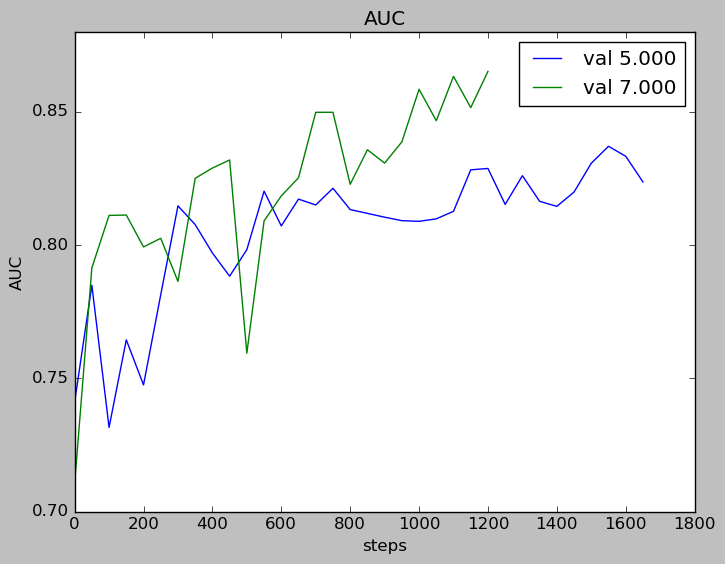

In [91]:
l_batch.plot_auc(batch_size_array)

#### batch_size=10, check learning rate

In [95]:
batch_size = 20
beta = 0
lr_array = np.array([.8, .7, .5, .1, .05, .01, .001, .0001]) #alpha
batch_size_array = np.ones(lr_array.shape)*batch_size
#beta = [2e-3, 5e-3, 1e-3]
beta_array = np.ones(lr_array.shape)*beta

l= lenet5_BN(train_dataset, valid_dataset, test_dataset, 
             train_labels, valid_labels, test_labels, recording_step= 10)

l.lenet5_BN(batch_size_array, lr_array, beta_array)

batch size:20 

learning rate : 0.8000

num_steps:421
Initialized
Minibatch loss at step 0: 3.400359
Minibatch accuracy: 50.0%


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Validation accuracy: 70.8%
AUC: 0.737
.................
Minibatch loss at step 250: 0.325943
Minibatch accuracy: 85.0%
Validation accuracy: 74.5%
AUC: 0.813
.................
Test accuracy: 75.7%
Test accuracy: 75.7%
Test AUC ROC: 0.843
-----------------------------------------

batch size:20 

learning rate : 0.7000

num_steps:421
Initialized
Minibatch loss at step 0: 5.047486
Minibatch accuracy: 40.0%
Validation accuracy: 72.1%
AUC: 0.776
.................
Minibatch loss at step 250: 0.355491
Minibatch accuracy: 85.0%
Validation accuracy: 79.0%
AUC: 0.867
.................
Test accuracy: 82.7%
Test accuracy: 82.7%
Test AUC ROC: 0.895
-----------------------------------------

batch size:20 

learning rate : 0.5000

num_steps:421
Initialized
Minibatch loss at step 0: 2.108280
Minibatch accuracy: 55.0%
Validation accuracy: 65.0%
AUC: 0.675
.................
Minibatch loss at step 250: 0.366012
Minibatch accuracy: 90.0%
Validation accuracy: 78.3%
AUC: 0.887
.................
Test accura

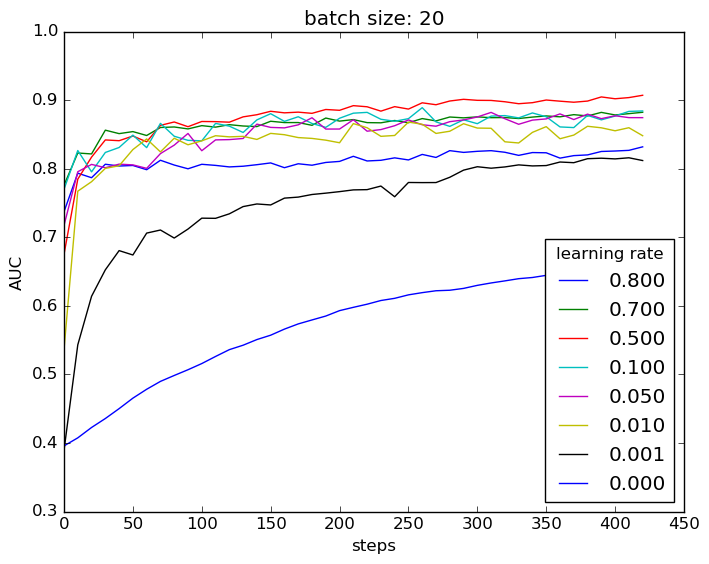

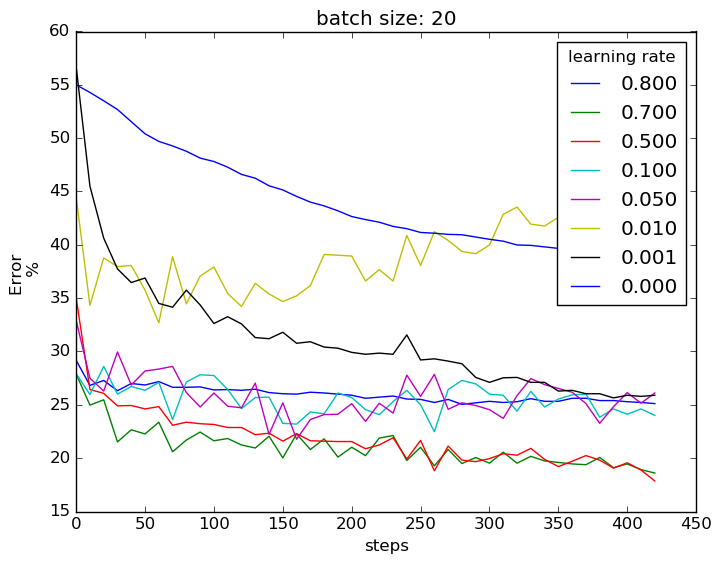

In [123]:
import matplotlib
matplotlib.style.use('classic')
fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l.pred_step_array):
    plt.plot(pred_step,l.valid_auc_array[i], label= '%.3f'%lr_array[i])
    #plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %.3f'%lr_array[i])
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(title= 'learning rate', loc= "best")
plt.title ('batch size: %d' %batch_size)
fig.savefig('./images/batch_size_%d_val_auc.png'%batch_size, format='png')
plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l.pred_step_array):
    plt.plot(pred_step, [100. - x for x in l.valid_accuracy_array[i]], label= '%.3f'%lr_array[i])
    #plt.plot(pred_step, [100. - x for x in l.test_accuracy_array[i]], label= 'test %d'%batch_size_array[i])
plt.xlabel('steps')
plt.ylabel('Error \n %')
plt.legend(title= 'learning rate', loc= "best")
plt.title ('batch size: %d' %batch_size)
fig.savefig('./images/batch_size_%d_val_error.png'%batch_size, format='png')
plt.show()


### change beta

In [159]:
batch_size = 10
lr= .005
beta_array = np.array([.1, .05, .01 , .001]) #
#beta_array = np.array([.05, .02]) #
batch_size_array = np.ones(beta_array.shape)*batch_size
#beta = [2e-3, 5e-3, 1e-3]
lr_array = np.ones(beta_array.shape)*lr

l= lenet5_BN(train_dataset, valid_dataset, test_dataset, 
             train_labels, valid_labels, test_labels, recording_step= 25)

l.lenet5_BN(batch_size_array, lr_array, beta_array)

batch size:10 

regularization : 0.1000

learning rate : 0.0050

num_steps:843
Initialized
Minibatch loss at step 0: 22.180170
Minibatch accuracy: 60.0%


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Validation accuracy: 34.2%
AUC: 0.288
.................
Minibatch loss at step 250: 14.645187
Minibatch accuracy: 70.0%
Validation accuracy: 75.7%
AUC: 0.834
.................
Minibatch loss at step 500: 11.113607
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
AUC: 0.825
.................
Minibatch loss at step 750: 9.351108
Minibatch accuracy: 80.0%
Validation accuracy: 72.7%
AUC: 0.817
.................
Test accuracy: 76.6%
Test accuracy: 76.6%
Test AUC ROC: 0.862
-----------------------------------------

batch size:10 

regularization : 0.0500

learning rate : 0.0050

num_steps:843
Initialized
Minibatch loss at step 0: 10.028237
Minibatch accuracy: 60.0%
Validation accuracy: 57.2%
AUC: 0.620
.................
Minibatch loss at step 250: 8.675507
Minibatch accuracy: 70.0%
Validation accuracy: 74.0%
AUC: 0.813
.................
Minibatch loss at step 500: 6.980564
Minibatch accuracy: 80.0%
Validation accuracy: 76.0%
AUC: 0.834
.................
Minibatch loss at step 750: 6.35

KeyboardInterrupt: 

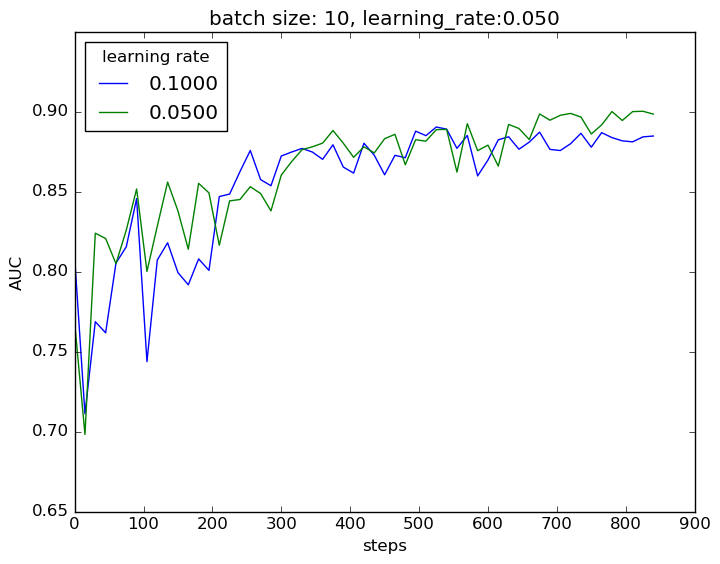

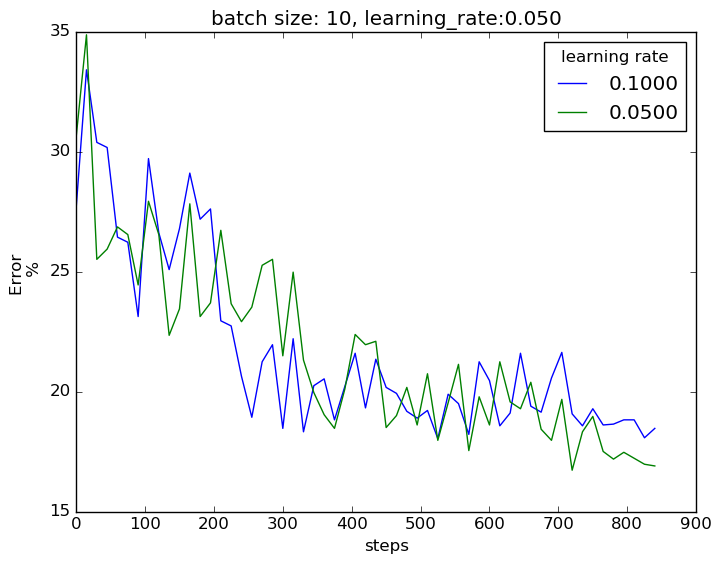

In [158]:
import matplotlib
matplotlib.style.use('classic')
fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l.pred_step_array):
    plt.plot(pred_step,l.valid_auc_array[i], label= '%.4f'%beta_array[i])
    #plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %.3f'%lr_array[i])
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(title= 'learning rate', loc= "best")
plt.title ('batch size: %d, learning_rate:%.3f' %(batch_size,lr))
fig.savefig('./images/batch_size_%d_lr_%.3f_val_auc.png' %(batch_size,lr), format='png')
plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l.pred_step_array):
    plt.plot(pred_step, [100. - x for x in l.valid_accuracy_array[i]],  label= '%.4f'%beta_array[i])    #plt.plot(pred_step, [100. - x for x in l.test_accuracy_array[i]], label= 'test %d'%batch_size_array[i])
plt.xlabel('steps')
plt.ylabel('Error \n %')
plt.legend(title= 'learning rate', loc= "best")
plt.title ('batch size: %d, learning_rate:%.3f' %(batch_size,lr))
fig.savefig('./images/batch_size_%d_lr_%.3f_val_error.png' %(batch_size,lr), format='png')
plt.show()


## CIFAR-10

In [40]:
# CIFAR-10 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

num_steps = 0
batch_size = 10
num_channels = 1
stride = 1 #1 very common


depth_1 = 1 # only one channel
depth_2 = 48
depth_3 = 128 #256
#depth_4 = 192
depth_5 = 192
depth_6 = 192
depth_7 = 128
#depth_8 = 192
depth_9 = 2048
depth_10 = 2048

pooling_size = 2

patch_size_1 = 4 
#pooling
patch_size_2 = pooling_size 
patch_size_3 = 2
#pooling
patch_size_4 = pooling_size
patch_size_5 = 3
patch_size_6 = 2
patch_size_7 = 2
#pooling
patch_size_8 = pooling_size
#patch_size_9 = 3 #FC
#patch_size_10 = 3 #FC


stride_1 = 3
stride_2 = 1 #pool
stride_4 = 1
stride_8 = 2


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size_1, patch_size_1, num_channels, depth_1], stddev=0.01))
  layer1_biases = tf.Variable(tf.zeros([depth_1]))
  #print (layer3_weights.get_shape().as_list())
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size_3, patch_size_3, depth_1, depth_3], stddev=0.01))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))

  layer5_weights = tf.Variable(tf.truncated_normal(
      [patch_size_5, patch_size_5, depth_3, depth_5], stddev=0.01)) #no sé si es depth_3 o depth_4 el primer argumento
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth_5]))

    
  layer6_weights = tf.Variable(tf.truncated_normal(
      [patch_size_6, patch_size_6, depth_5, depth_6], stddev=0.01))
  layer6_biases = tf.Variable(tf.constant(1.0, shape=[depth_6]))
  
  layer7_weights = tf.Variable(tf.truncated_normal(
      [patch_size_7, patch_size_7, depth_6, depth_7], stddev=0.01)) #no sé si es depth_3 o depth_4 el primer argumento
  layer7_biases = tf.Variable(tf.constant(1.0, shape=[depth_7]))
    
  #layer9_weights = tf.Variable(tf.truncated_normal(
  #    [(image_height // ( patch_size_4*stride_1*stride_2*stride_8)) * 
  #     (image_width // (patch_size_4*stride_1*stride_2*(stride_8))) * depth_7, depth_9], stddev=0.01)) #modified for variable height and width  
  
  layer9_weights = tf.Variable(tf.truncated_normal([depth_7, depth_9], stddev=0.01)) #modified for variable height and width  
  
  print (layer9_weights.get_shape().as_list())
  layer9_biases = tf.Variable(tf.constant(1.0, shape=[depth_9]))
  layer10_weights = tf.Variable(tf.truncated_normal(
      [depth_9, num_labels], stddev=0.01))
  layer10_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride_1, stride_1, 1], padding='VALID')
    print (conv1.get_shape().as_list())
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool2 = tf.nn.max_pool(hidden1, ksize=[1, patch_size_2, patch_size_2, 1], strides=[1, stride_2, stride_2, 1], 
                           padding='VALID')
    print (pool2.get_shape().as_list())
    
    conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, stride, stride, 1], padding='VALID')
    print (conv3.get_shape().as_list())
    hidden3 = tf.nn.relu(conv3 + layer3_biases)
    pool4 = tf.nn.max_pool(hidden3, ksize=[1,  patch_size_4, patch_size_4 , 1], strides=[1, stride_4, stride_4, 1], 
                           padding='VALID')    
    
    print (pool4.get_shape().as_list())
    
    
    conv5 = tf.nn.conv2d(pool4, layer5_weights, [1, stride, stride, 1], padding='VALID')
    print (conv5.get_shape().as_list())
    hidden5 = tf.nn.relu(conv5 + layer5_biases)
    conv6 = tf.nn.conv2d(hidden5, layer6_weights, [1, stride, stride, 1], padding='VALID')
    print (conv6.get_shape().as_list())
    hidden6 = tf.nn.relu(conv6 + layer6_biases)
    
    conv7 = tf.nn.conv2d(hidden6, layer7_weights, [1, stride, stride, 1], padding='VALID')
    
    print (conv7.get_shape().as_list())
    hidden7 = tf.nn.relu(conv7 + layer7_biases)
    
    pool8 = tf.nn.max_pool(hidden7, ksize=[1,  patch_size_8, patch_size_8 , 1], strides=[1, stride_8, stride_8, 1], 
                           padding='VALID')
    
    
    
    shape = pool8.get_shape().as_list()
    reshape = tf.reshape(pool8, [shape[0], shape[1] * shape[2] * shape[3]])    
    
    #shape = hidden7.get_shape().as_list() #No sense to do pooling since there is not data remainin [1,1]

    #reshape = tf.reshape(hidden7, [shape[0], shape[1] * shape[2] * shape[3]])    
    print (reshape.get_shape().as_list())  
    hidden9 = tf.nn.relu(tf.matmul(reshape, layer9_weights) + layer9_biases)
    print (hidden9.get_shape().as_list())  
    
    return (tf.matmul(hidden9, layer10_weights) + layer10_biases)
  
    
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  5
    
  #Regularization: 

  regularization_beta = 0.0005 
  regularizers = (tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + 
                   tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))

  loss = loss + regularization_beta * regularizers
  # Optimizer.
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  #decaying learning rate:
  starting_learning_rate = 0.01
  learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 1501, 0.8, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[128, 2048]
[10, 10, 10, 1]
[10, 9, 9, 1]
[10, 8, 8, 128]
[10, 7, 7, 128]
[10, 5, 5, 192]
[10, 4, 4, 192]
[10, 3, 3, 128]
[10, 128]
[10, 2048]
[2811, 10, 10, 1]
[2811, 9, 9, 1]
[2811, 8, 8, 128]
[2811, 7, 7, 128]
[2811, 5, 5, 192]
[2811, 4, 4, 192]
[2811, 3, 3, 128]
[2811, 128]
[2811, 2048]
[2811, 10, 10, 1]
[2811, 9, 9, 1]
[2811, 8, 8, 128]
[2811, 7, 7, 128]
[2811, 5, 5, 192]
[2811, 4, 4, 192]
[2811, 3, 3, 128]
[2811, 128]
[2811, 2048]


In [41]:
num_steps = train_dataset.shape[0] // batch_size

#num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
valid_auc = []
test_accuracy = []
test_auc = []
pred_step = []
from sklearn.metrics import roc_auc_score

with tf.device('/gpu:0'):
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 250 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
          print('AUC: %.3f' %  roc_auc_score(valid_labels, valid_prediction.eval()))
          print (".................")
        
        if (step % 50 == 0):
          valid_accuracy.append(accuracy(
                valid_prediction.eval(), valid_labels))
          valid_auc.append(roc_auc_score(valid_labels, valid_prediction.eval()))
          test_accuracy.append(accuracy(
                test_prediction.eval(), test_labels))
          test_auc.append(roc_auc_score(test_labels, test_prediction.eval()))
          pred_step.append(step)
      print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
      print('Test AUC ROC: %.3f' %  roc_auc_score(test_labels, test_prediction.eval()))  


num_steps:843
Initialized
Minibatch loss at step 0: 0.796456
Minibatch accuracy: 50.0%
Validation accuracy: 50.0%
AUC: 0.581
.................
Minibatch loss at step 250: 0.799928
Minibatch accuracy: 30.0%
Validation accuracy: 50.0%
AUC: 0.813
.................
Minibatch loss at step 500: 0.690534
Minibatch accuracy: 80.0%
Validation accuracy: 76.0%
AUC: 0.904
.................
Minibatch loss at step 750: 0.310762
Minibatch accuracy: 100.0%
Validation accuracy: 87.3%
AUC: 0.908
.................
Test accuracy: 88.0%
Test AUC ROC: 0.907


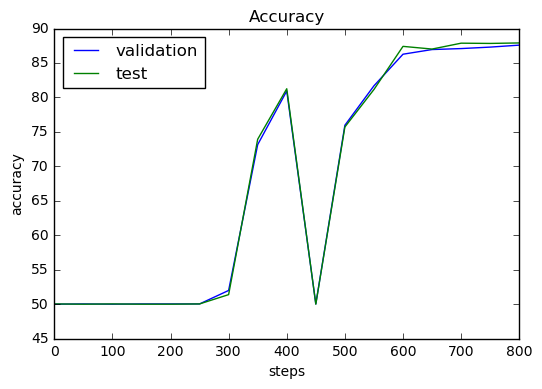

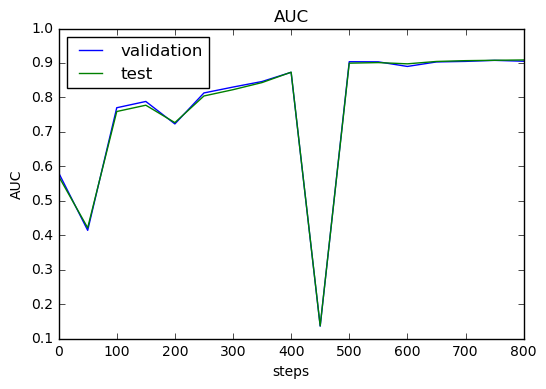

In [42]:
%matplotlib inline 
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend(loc= "best")
plt.title ("Accuracy")
plt.show()

plt.plot(pred_step,valid_auc, label= 'validation')
plt.plot(pred_step,test_auc, label= 'test')
plt.xlabel('steps')
plt.ylabel('AUC')
plt.legend(loc= "best")
plt.title ("AUC")
plt.show()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [39]:
batch_size = 16
patch_size = 2
depth = 16
num_hidden = 64
num_channels = 1
stride = 2


#---------------------
batch_size = 20
patch_size = 4
depth = 6
num_hidden = 32
num_channels = 1
stride = 4
pooling = 2

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  #layer3_weights = tf.Variable(tf.truncated_normal(
  #    [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1)) #modified for variable height and width
  layer3_weights = tf.Variable(tf.truncated_normal(
      [(image_height // (stride**2*pooling**2)) * (image_width // (stride**2*pooling**2)) * depth, num_hidden], stddev=0.1)) #modified for variable height and width  

  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride, stride, 1], padding='VALID')
    print (conv1.get_shape().as_list())
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, ksize=[1, 2, 2, 1], strides=[1, pooling, pooling, 1], padding='SAME')
    print (pool1.get_shape().as_list())
    
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, stride, stride, 1], padding='VALID')
    print (conv2.get_shape().as_list())
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, ksize=[1, 2, 2, 1], strides=[1, pooling, pooling, 1], padding='SAME')    
    print (pool2.get_shape().as_list())
    
    shape = pool2.get_shape().as_list()

    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])    
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    return (tf.matmul(hidden3, layer4_weights) + layer4_biases)
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.3).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[20, 32, 32, 6]
[20, 16, 16, 6]
[20, 4, 4, 6]
[20, 2, 2, 6]
[2811, 32, 32, 6]
[2811, 16, 16, 6]
[2811, 4, 4, 6]
[2811, 2, 2, 6]
[2811, 32, 32, 6]
[2811, 16, 16, 6]
[2811, 4, 4, 6]
[2811, 2, 2, 6]


In [40]:
num_steps = train_dataset.shape[0] // batch_size

#num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
test_accuracy = []
pred_step = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #do not randomize train dataset each step: it is learning from slices and it will go mad!
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print ("offset %d" %offset)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 250 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
    if (step % 250 == 0):
      valid_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(
            test_prediction.eval(), test_labels))
      pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

num_steps:421
Initialized
Minibatch loss at step 0: 1.215984
Minibatch accuracy: 40.0%
Validation accuracy: 50.0%
Minibatch loss at step 250: 0.514865
Minibatch accuracy: 75.0%
Validation accuracy: 73.2%
Test accuracy: 78.4%


In [5]:
batch_size = 20
patch_size = 5
depth = 6
num_hidden = 64
num_channels = 1
stride = 2 #1 very common



graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  #layer3_weights = tf.Variable(tf.truncated_normal(
  #    [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1)) #modified for variable height and width
  layer3_weights = tf.Variable(tf.truncated_normal(
      [(image_height // stride**2) * (image_width // stride**2) * depth, num_hidden], stddev=0.1)) #modified for variable height and width  
  #print (layer3_weights.get_shape().as_list())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, stride,stride, 1], padding='SAME')
    #print (conv.get_shape().as_list())
    hidden = tf.nn.relu(conv + layer1_biases)
    #print (hidden.get_shape().as_list())
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, stride, stride, 1], padding='SAME')
    #print (conv.get_shape().as_list())
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    #print (hidden.get_shape().as_list())
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return (tf.matmul(hidden, layer4_weights) + layer4_biases)
  
    
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  #decaying learning rate:
  starting_learning_rate = 0.1
  learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 2001, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

NameError: name 'num_steps' is not defined

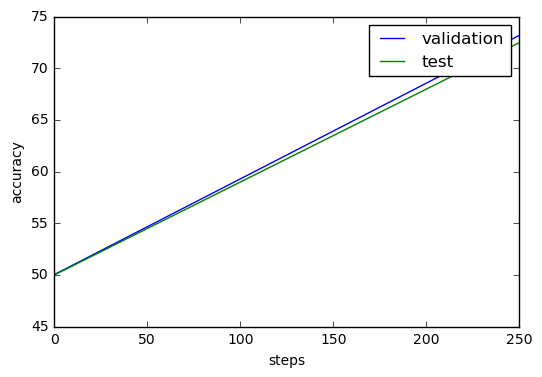

In [41]:
%matplotlib inline 
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()

In [167]:
num_steps = 1000

valid_accuracy = []
test_accuracy = []
pred_step = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for batch_size in batch_array:
      for step in range(num_steps):
        #do not randomize train dataset each step: it is learning from slices and it will go mad!
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
          valid_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
          test_accuracy.append(accuracy(
            test_prediction.eval(), test_labels))
          pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


NameError: name 'batch_array' is not defined

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---